In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#cd "/content/drive/MyDrive/논문프로젝트"

In [ ]:
#!git clone https://github.com/huggingface/peft.git

In [ ]:
import torch
import torch.nn as nn

class LayerwiseFGFourierFT(nn.Module):
    def __init__(
        self,
        n: int = 100,
        alpha: float = 300.0,
        d1: int = 4096,
        d2: int = 4096,
        base_layer: nn.Module = None,
        delta_W_init: torch.Tensor = None,
        top_k_ratio: float = 0.05
    ):
        super(LayerwiseFGFourierFT, self).__init__()

        # Definitions
        self.d1 = d1
        self.d2 = d2
        self.alpha = alpha
        self.base_layer = base_layer

        # delta_W_init (초기 가중치 변화량)을 FFT로 변환
        W_freq = torch.fft.fft2(delta_W_init)
        magnitude = torch.abs(W_freq)

        # 중요 주파수 위치 선정 (top-k 방식)
        total_freq = d1 * d2
        k = int(total_freq * top_k_ratio)
        topk_values, topk_indices = torch.topk(magnitude.view(-1), k)

        # Frequency mask 생성 (중요 주파수 위치는 1, 나머지는 0)
        self.mask = torch.zeros((d1, d2), dtype=torch.bool)
        self.mask.view(-1)[topk_indices] = True

        # 중요 주파수 위치의 초기값만 학습 파라미터로 설정
        self.c = nn.Parameter(W_freq[self.mask].clone().detach(), requires_grad=True)

    def forward(self, x: torch.Tensor):
        # 스펙트럼 행렬 생성 및 중요 위치만 채워넣기
        F = torch.zeros(self.d1, self.d2, dtype=torch.complex64, device=x.device)
        F[self.mask] = self.c


        Delta_W = torch.fft.ifft2(F).real * self.alpha


        h = self.base_layer(x)
        h += torch.einsum('ijk,kl->ijl', x, Delta_W)

        return h


In [ ]:
!pip install transformers datasets matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
import matplotlib.pyplot as plt
import time



In [ ]:
dataset = load_dataset("cifar100")

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

def preprocess(example):
    inputs = feature_extractor(example["img"], return_tensors="pt")
    inputs["labels"] = example["fine_label"]
    return inputs

dataset = dataset.with_transform(preprocess)

train_loader = DataLoader(dataset["train"], batch_size=32, shuffle=True)
test_loader = DataLoader(dataset["test"], batch_size=32)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.98k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# 최적의 파라미터 탐색 요구


In [ ]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=100
)

# ViT의 attention의 query 가중치 교체 예시
for i, layer in enumerate(model.vit.encoder.layer):
    original_linear = layer.attention.attention.query
    delta_W_init = original_linear.weight.data.clone() * 0.01

    layer.attention.attention.query = LayerwiseFGFourierFT(
        n=100,
        alpha=12,
        d1=original_linear.weight.size(0),
        d2=original_linear.weight.size(1),
        base_layer=original_linear,
        delta_W_init=delta_W_init,
        top_k_ratio=0.5
    )


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# 학습 가능한 파라미터 수 체크
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"학습 가능한 파라미터 수: {trainable_params:,}")


학습 가능한 파라미터 수: 89,414,500


# vision task
- 에폭 = 10


In [ ]:
epochs = 10
epoch_train_acc = []
epoch_train_loss = []

start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in train_loader:
        inputs = batch['pixel_values'].squeeze(1).to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_acc = 100.*correct/total
    epoch_loss = total_loss/len(train_loader)
    epoch_train_acc.append(epoch_acc)
    epoch_train_loss.append(epoch_loss)

    epoch_time = time.time() - epoch_start
    print(f"[Epoch {epoch+1}/{epochs}] Loss: {epoch_loss:.4f}, "
          f"Accuracy: {epoch_acc:.2f}%, 소요시간: {epoch_time:.2f}초")

total_time = time.time() - start_time
print(f"\n총 훈련 소요시간: {total_time:.2f}초")


[Epoch 1/10] Loss: 3.6055, Accuracy: 65.12%, 소요시간: 511.57초
[Epoch 2/10] Loss: 1.8892, Accuracy: 88.44%, 소요시간: 510.80초
[Epoch 3/10] Loss: 0.8945, Accuracy: 93.24%, 소요시간: 511.26초
[Epoch 4/10] Loss: 0.4263, Accuracy: 95.83%, 소요시간: 511.00초
[Epoch 5/10] Loss: 0.2232, Accuracy: 97.35%, 소요시간: 510.95초
[Epoch 6/10] Loss: 0.1290, Accuracy: 98.27%, 소요시간: 510.89초
[Epoch 7/10] Loss: 0.0806, Accuracy: 98.83%, 소요시간: 510.89초
[Epoch 8/10] Loss: 0.0543, Accuracy: 99.21%, 소요시간: 510.60초
[Epoch 9/10] Loss: 0.0400, Accuracy: 99.36%, 소요시간: 511.44초
[Epoch 10/10] Loss: 0.0276, Accuracy: 99.56%, 소요시간: 512.60초

총 훈련 소요시간: 5111.99초


In [ ]:
model.eval()
correct, total = 0, 0
eval_start = time.time()

with torch.no_grad():
    for batch in test_loader:
        inputs = batch['pixel_values'].squeeze(1).to(device)
        labels = batch['labels'].to(device)
        outputs = model(inputs)
        _, predicted = outputs.logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

eval_time = time.time() - eval_start
test_acc = 100.*correct/total
print(f"Test Accuracy: {test_acc:.2f}%, 평가 소요시간: {eval_time:.2f}초")


Test Accuracy: 90.71%, 평가 소요시간: 48.00초


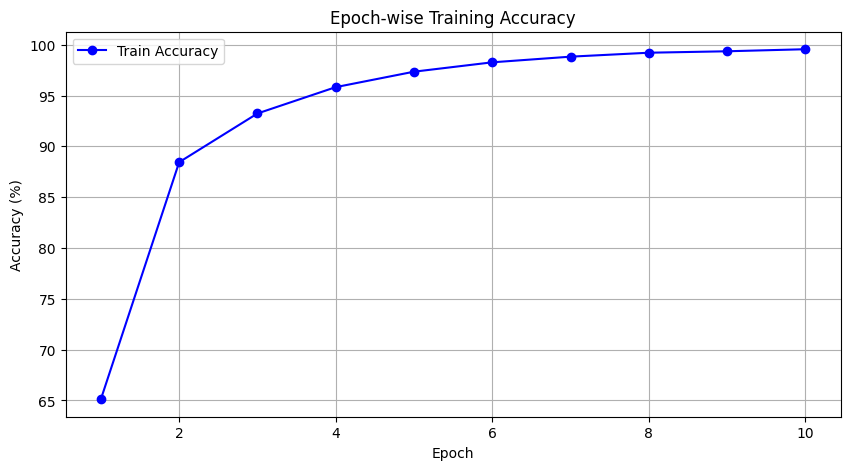

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), epoch_train_acc, marker='o', color='blue', label='Train Accuracy')
plt.title('Epoch-wise Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.legend()
plt.show()


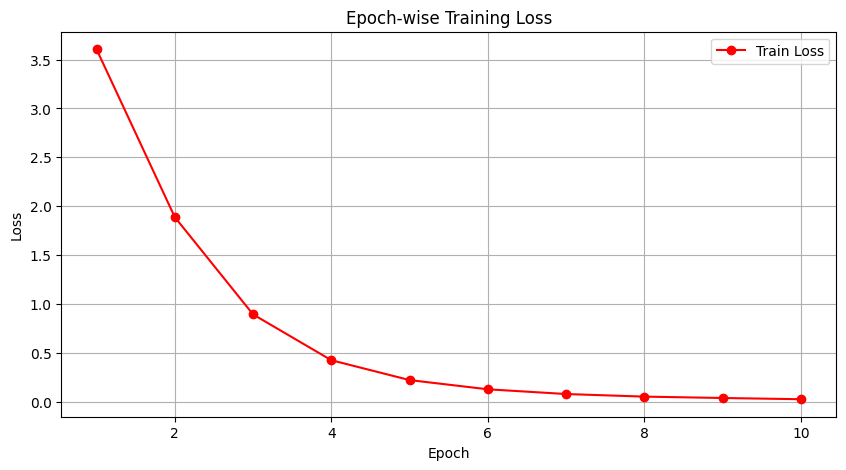

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), epoch_train_loss, marker='o', color='red', label='Train Loss')
plt.title('Epoch-wise Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()


In [ ]:
trainable_fourier_params = 0

for name, module in model.named_modules():
    if isinstance(module, LayerwiseFGFourierFT):
        trainable_fourier_params += module.c.numel()

print(f"FourierFT로 파인튜닝 시 학습 가능한 총 파라미터 수: {trainable_fourier_params:,}")

FourierFT로 파인튜닝 시 학습 가능한 총 파라미터 수: 3,538,944
